In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, balanced_accuracy_score, 
                             confusion_matrix, classification_report, silhouette_score)
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [42]:
DATA_FILE = 'data/Peoples_Climate_Vote_Database_2024.xlsx'
PREPROCESSED_DATA_FILE = 'data/preprocessed_climate_data.csv'
N_CLUSTERS = 3

In [43]:
def create_feature_names_predictive(question, response):
    question_map = {
        'Countries working together': 'Collab',
        'Rich countries helping poor': 'RichHelp',
        'Thinking about climate change': 'ThinkClimate',
        'Worry compared to last year': 'WorryVsLastYr',
        'Worry for next generation': 'WorryNextGen',
        'Extreme weather experience': 'ExtremeWeather',
        'Effects on big decisions': 'EffectDecisions',
        'Strengthening commitments': 'TARGET_Strengthen', 
        'Renewable energy transition': 'RenewableTransition',
        'Protect and restore nature': 'ProtectNature',
        'Protection from extreme weather': 'WeatherProtection',
        'Teaching about climate change': 'TeachClimate',
        'Country performance': 'CountryPerf',
        'Big businesses performance': 'BusinessPerf',
        'Who has had most impact': 'MostImpact'
    }
    
    response_map = {
        # General responses
        "Don't know": 'DontKnow',
        'About the same as now': 'Same',
        'About the same': 'Same',
        'About the same as usual': 'Same',
        
        # Countries working together
        'Yes - they should work together despite their disagreements': 'Yes',
        'No - they should work separately': 'No',
        "It doesn't matter - no country should work on climate change": 'DoesntMatter',
        
        # Rich countries helping
        'More help': 'More',
        'Less help': 'Less',
        
        # Thinking frequency
        'Daily': 'Daily',
        'Weekly': 'Weekly',
        'A few times a year': 'FewTimesYear',
        'Never': 'Never',
        
        # Worry levels
        'More worried': 'More',
        'Less worried': 'Less',
        'Extremely': 'Extremely',
        'Very': 'Very',
        'Somewhat': 'Somewhat',
        'Not very': 'NotVery',
        'Not at all': 'NotAtAll',
        
        # Weather experience
        'Worse than usual': 'Worse',
        'Better than usual': 'Better',
        
        # Impact levels
        'A lot': 'ALot',
        'A little': 'ALittle',
        
        # Commitments (target variable responses)
        'Strengthen': 'Strengthen',
        'Keep them the same': 'KeepSame',
        'Weaken': 'Weaken',
        
        # Transition speed
        'Very quickly': 'VeryQuickly',
        'Somewhat quickly': 'SomewhatQuickly',
        'Slowly': 'Slowly',
        
        # Protection
        'More protection': 'More',
        'Less protection': 'Less',
        'More': 'More',
        'Less': 'Less',
        
        # Performance ratings
        'Very well': 'VeryWell',
        'Somewhat well': 'SomewhatWell',
        'Neither well nor badly': 'Neutral',
        'Somewhat badly': 'SomewhatBadly',
        'Very badly': 'VeryBadly',
        
        # Impact actors
        'Government': 'Govt',
        'The United Nations': 'UN',
        'Campaigners and activists': 'Activists',
        'Faith and community leaders': 'FaithLeaders',
        'Big business': 'BigBiz',
        'The European Union (EU)': 'EU'
    }
    
    q_short = question_map.get(question, question)
    r_short = response_map.get(response, response)
    
    return f"{q_short}_{r_short}"

In [44]:
# Preprocessing function that transforms raw survey data into ML-ready format.
def preprocess_climate_data(file_path):
    print('Loading and filter data....')
    df = pd.read_excel(file_path)
    
    df = df[df['Country']!= 'Global']
    
    # Filter only the adult age groups with 'All Education' aggregate.
    age_categories = ['18 to 35', '36 to 59', '60 plus']
    df_by_age = df[(df['Age'].isin(age_categories)) & (df['Education'] == 'All Education')]
    
    print("Original rows: ", len(df))
    print("After filtering by age: ", len(df_by_age))
    
    print('Identify complete observations...')
    
    complete_groups = []
    
    for (country, age), group_data in df_by_age.groupby(['Country', 'Age']):
        answered_questions = group_data[group_data['Weighted Mean'].notna()]['Question Text (Short)'].nunique()
        
        if answered_questions == 15:
            complete_groups.append({'Country': country, 'Age': age})
            
    grouped_df = pd.DataFrame(complete_groups)
    pairs = set(zip(grouped_df['Country'], grouped_df['Age']))
    
    complete_groups_df = df_by_age[df_by_age.apply(lambda row: (row['Country'], row['Age']) in pairs, axis=1)].copy()
    
    print('Total number of complete groups: ', len(complete_groups_df))
    
    print('Converting from long to wider format...')
    
    complete_groups_df['Feature'] = complete_groups_df.apply(
        lambda row: create_feature_names_predictive(row['Question Text (Short)'], row['Response']),
        axis= 1)
    
    # Pivot: transform so each group becomes one row
    wided_df = complete_groups_df.pivot_table(
        index=['Country', 'Age'],
        columns='Feature',
        values='Weighted Mean',
        aggfunc='first'
    ).reset_index()
    
    wided_df.columns.name = None
    print('Wide format: ', wided_df.shape)
    
    print('Creating binary target variable...')
    
    median_support = wided_df['TARGET_Strengthen_Strengthen'].median()
    wided_df['Target_Binary'] = (wided_df['TARGET_Strengthen_Strengthen'] > median_support).astype(int)
    
    print('Threshold: ', median_support, " %")
    print(f"Class 1 (strong support): {(wided_df['Target_Binary'] == 1).sum()}")
    print(f"Class 0 (moderate support): {(wided_df['Target_Binary'] == 0).sum()}")
    
    print('Encoding demographic features....')
    age_encoding = {'18 to 35': 1, '36 to 59': 2, '60 plus': 3}
    wided_df['Age_Numeric'] = wided_df['Age'].map(age_encoding)
    
    target_cols = [col for col in wided_df.columns if col.startswith('TARGET_')]
    demographic_cols = ['Country', 'Age']
    exclude_cols = target_cols + demographic_cols + ['Target_Binary', 'Age_Numeric']
    
    feature_cols = [col for col in wided_df.columns if col not in exclude_cols]
    feature_cols.append('Age_Numeric')
    
    print('Total features: ', len(feature_cols))
    print('\n---- Preprocessing completed -----')
    
    return wided_df, feature_cols

In [45]:
preprocessed_data, features = preprocess_climate_data(DATA_FILE)
preprocessed_data.to_csv(PREPROCESSED_DATA_FILE, index=False)
print(f"\nSaved preprocessed data to: {PREPROCESSED_DATA_FILE}")

print("DATASET SUMMARY")
print("Observations: ", len(preprocessed_data))
print("Features: ", len(features))
print("Target: Target_Binary (0 = moderate support, 1 = strong support)")
print("Class balance: ", preprocessed_data['Target_Binary'].value_counts().to_dict())


Loading and filter data....
Original rows:  45145
After filtering by age:  15336
Identify complete observations...
Total number of complete groups:  10011
Converting from long to wider format...
Wide format:  (141, 73)
Creating binary target variable...
Threshold:  85.0  %
Class 1 (strong support): 66
Class 0 (moderate support): 75
Encoding demographic features....
Total features:  68

---- Preprocessing completed -----

Saved preprocessed data to: data/preprocessed_climate_data.csv
DATASET SUMMARY
Observations:  141
Features:  68
Target: Target_Binary (0 = moderate support, 1 = strong support)
Class balance:  {0: 75, 1: 66}


In [46]:
# Load preprocessed data and prepare X (features) and y (target).
def load_preprocessed_data(file_path):
    df = pd.read_csv(file_path)
    
    # columns to be excluded from features.
    excludes_from_features = {
        'Country',                        
        'Age',                            
        'Target_Binary',                  
        'TARGET_Strengthen_Strengthen',   
        'TARGET_Strengthen_KeepSame',     
        'TARGET_Strengthen_Weaken',       
        'TARGET_Strengthen_DontKnow'  
    }
    
    features_cols = [col for col in df.columns if col not in excludes_from_features]
    
    X = df[features_cols]
    y = df['Target_Binary']
    
    return X, y, features_cols, df
    

In [47]:
# Train and evaluate Logistic Regression model.
def logistic_regression(X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred)
    }
    
    return model, y_pred, metrics, scaler

In [48]:
# Train and evaluate Random Forest model.
def random_forest(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred)
    }
    
    return model, y_pred, metrics

In [49]:
def get_features(lr, rf, feature_cols, scaler):
    lr_features = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': lr.coef_[0],
        'Abs_Coefficient': np.abs(lr.coef_[0])
    }).sort_values('Abs_Coefficient', ascending= False)
    
    rf_features = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    return lr_features, rf_features
    

In [69]:
# comparison of model performance.
def model_comparison(lr, rf):
    print("MODEL PERFORMANCE COMPARISON")
    print(f"\n{'Metric':<25} {'Logistic Regression':<20} {'Random Forest':<20}")
    
    for metric in ['Accuracy', 'F1 Score', 'Balanced Accuracy']:
        lr_val = lr[metric]
        rf_val = rf[metric]
        winner = "*" if lr_val > rf_val else ""
        winner_rf = "*" if rf_val > lr_val else ""
        print(f"{metric:<25} {lr_val:.4f} {winner:<15} {rf_val:.4f} {winner_rf}")
    
    print("\n* = Better performing model")

In [51]:
def feature_importance(lr, rf, top_n = 15):
    print(f"TOP {top_n} FEATURES - LOGISTIC REGRESSION")
    print(f"{'Rank':<6} {'Feature':<40} {'Coefficient':<12}")
    
    for idx, row in lr.head(top_n).iterrows():
        rank = lr.index.get_loc(idx) + 1
        direction = "+" if row['Coefficient'] > 0 else ""
        print(f"{rank:<6} {row['Feature']:<40} {direction}{row['Coefficient']:.4f}")
        
   
    print(f"TOP {top_n} FEATURES - RANDOM FOREST")
    print(f"{'Rank':<6} {'Feature':<40} {'Importance':<12}")
    
    for idx, row in rf.head(top_n).iterrows():
        rank = rf.index.get_loc(idx) + 1
        print(f"{rank:<6} {row['Feature']:<40} {row['Importance']:.4f}")
    

In [52]:
def analyse_demographics_vs_attitudes(lr, rf):
    print("DEMOGRAPHICS VS ATTITUDES ANALYSIS")
    
    lr_ranks = lr.reset_index(drop=True)
    lr_ranks['Rank'] = range(1, len(lr_ranks) + 1)
    
    rf_ranks = rf.reset_index(drop=True)
    rf_ranks['Rank'] = range(1, len(rf_ranks) + 1)
    
    lr_age_rank = lr_ranks[lr_ranks['Feature'] == 'Age_Numeric']['Rank'].values[0]
    rf_age_rank = rf_ranks[rf_ranks['Feature'] == 'Age_Numeric']['Rank'].values[0]
    
    total_features = len(lr)
    
    print("\nAge_Numeric (demographic feature) ranking:")
    print(f"Logistic Regression: {lr_age_rank} out of {total_features}")
    print(f"Random Forest:       {rf_age_rank} out of {total_features}")
    
    print("\nCONCLUSION: Age ranks very low in both models.")
    print("ATTITUDES matter significantly more than demographics!")


In [68]:
def plot_model_comparison(lr_metrics, rf_metrics):
    metrics = ['Accuracy', 'F1 Score', 'Balanced Accuracy']
    lr_values = [lr_metrics[m] for m in metrics]
    rf_values = [rf_metrics[m] for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, lr_values, width, label='Logistic Regression', color='steelblue')
    bars2 = ax.bar(x + width/2, rf_values, width, label='Random Forest', color='forestgreen')
    
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)
    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_feature_importance_comparison(lr_importance, rf_importance, top_n=10):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Logistic Regression
    top_lr = lr_importance.head(top_n)
    colors_lr = ['green' if c > 0 else 'red' for c in top_lr['Coefficient']]
    axes[0].barh(range(top_n), top_lr['Abs_Coefficient'], color=colors_lr, alpha=0.7)
    axes[0].set_yticks(range(top_n))
    axes[0].set_yticklabels(top_lr['Feature'])
    axes[0].invert_yaxis()
    axes[0].set_xlabel('|Coefficient|')
    axes[0].set_title('Logistic Regression\n(Green=Positive, Red=Negative)')
    
    # Random Forest
    top_rf = rf_importance.head(top_n)
    axes[1].barh(range(top_n), top_rf['Importance'], color='skyblue', alpha=0.7)
    axes[1].set_yticks(range(top_n))
    axes[1].set_yticklabels(top_rf['Feature'])
    axes[1].invert_yaxis()
    axes[1].set_xlabel('Feature Importance')
    axes[1].set_title('Random Forest')
    
    plt.suptitle('Top 5 Feature Importance: Logistic Regression vs Random Forest', fontsize=14)
    plt.tight_layout()
    plt.show()

In [74]:
def plot_demographics_vs_attitudes(lr_importance, rf_importance):
    # Get ranks
    lr_ranks = lr_importance.reset_index(drop=True)
    lr_ranks['Rank'] = range(1, len(lr_ranks) + 1)
    
    rf_ranks = rf_importance.reset_index(drop=True)
    rf_ranks['Rank'] = range(1, len(rf_ranks) + 1)
    
    lr_age_rank = lr_ranks[lr_ranks['Feature'] == 'Age_Numeric']['Rank'].values[0]
    rf_age_rank = rf_ranks[rf_ranks['Feature'] == 'Age_Numeric']['Rank'].values[0]
    total = len(lr_importance)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = ['Logistic Regression', 'Random Forest']
    age_ranks = [lr_age_rank, rf_age_rank]
    
    bars = ax.bar(x, age_ranks, color=['steelblue', 'forestgreen'], edgecolor='black')
    
    ax.axhline(y=total/2, color='red', linestyle='--', label=f'Median rank ({total//2})')
    ax.axhline(y=total, color='gray', linestyle=':', alpha=0.5)
    
    ax.set_ylabel('Feature Rank (lower = more important)')
    ax.set_title(f'Age_Numeric (Demographic) Rank Out of {total} Features\n'
                 f'Higher rank = LESS important')
    ax.set_ylim(0, total + 5)
    ax.legend()
    
    # Add labels
    for bar, rank in zip(bars, age_ranks):
        ax.annotate(f'Rank {rank}\n(bottom {100-rank/total*100:.0f}%)', 
                    xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    xytext=(0, 5), textcoords="offset points", ha='center', fontsize=11)
    
    # Add conclusion text
    ax.text(0.5, 0.02, 'CONCLUSION: Age ranks near bottom → ATTITUDES matter more than demographics!',
            transform=ax.transAxes, ha='center', fontsize=11, 
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

Loading preprocessed data...
Dataset: 141 observations, 68 features
Target distribution: {0: 75, 1: 66}

Training set: 112 observations
Test set: 29 observations
Training Logistic Regression...
Logistic Regression Done!

Training Random Forest...
Random Forest Done!
MODEL PERFORMANCE COMPARISON

Metric                    Logistic Regression  Random Forest       
Accuracy                  0.8276 *               0.7241 
F1 Score                  0.8276 *               0.7143 
Balanced Accuracy         0.8286 *               0.7238 

* = Better performing model
TOP 5 FEATURES - LOGISTIC REGRESSION
Rank   Feature                                  Coefficient 
1      Collab_DontKnow                          +0.9372
2      BusinessPerf_VeryWell                    -0.9250
3      WorryNextGen_NotVery                     -0.8483
4      TeachClimate_Same                        -0.8216
5      ThinkClimate_DontKnow                    -0.8115
TOP 5 FEATURES - RANDOM FOREST
Rank   Feature            

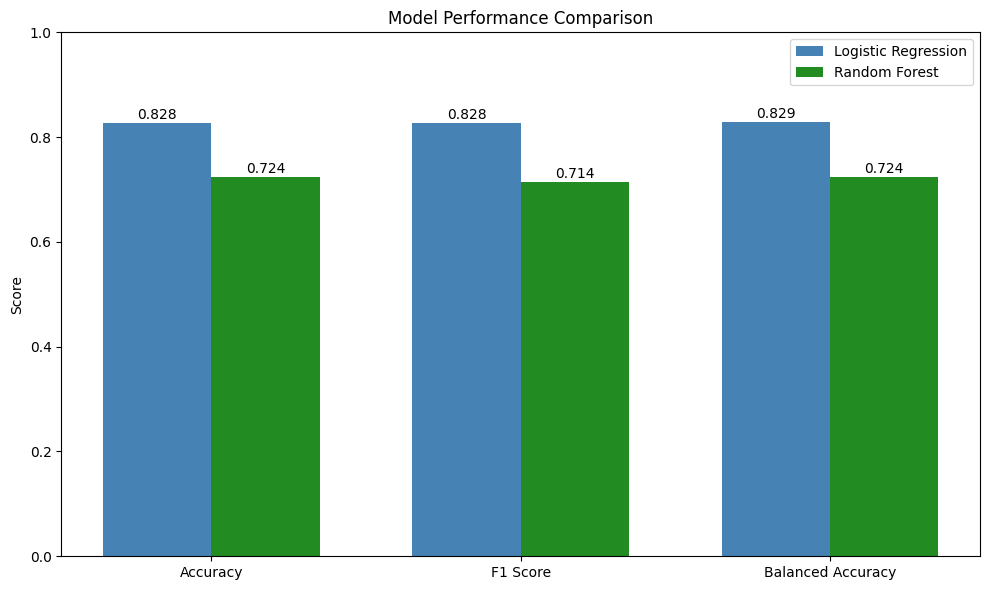

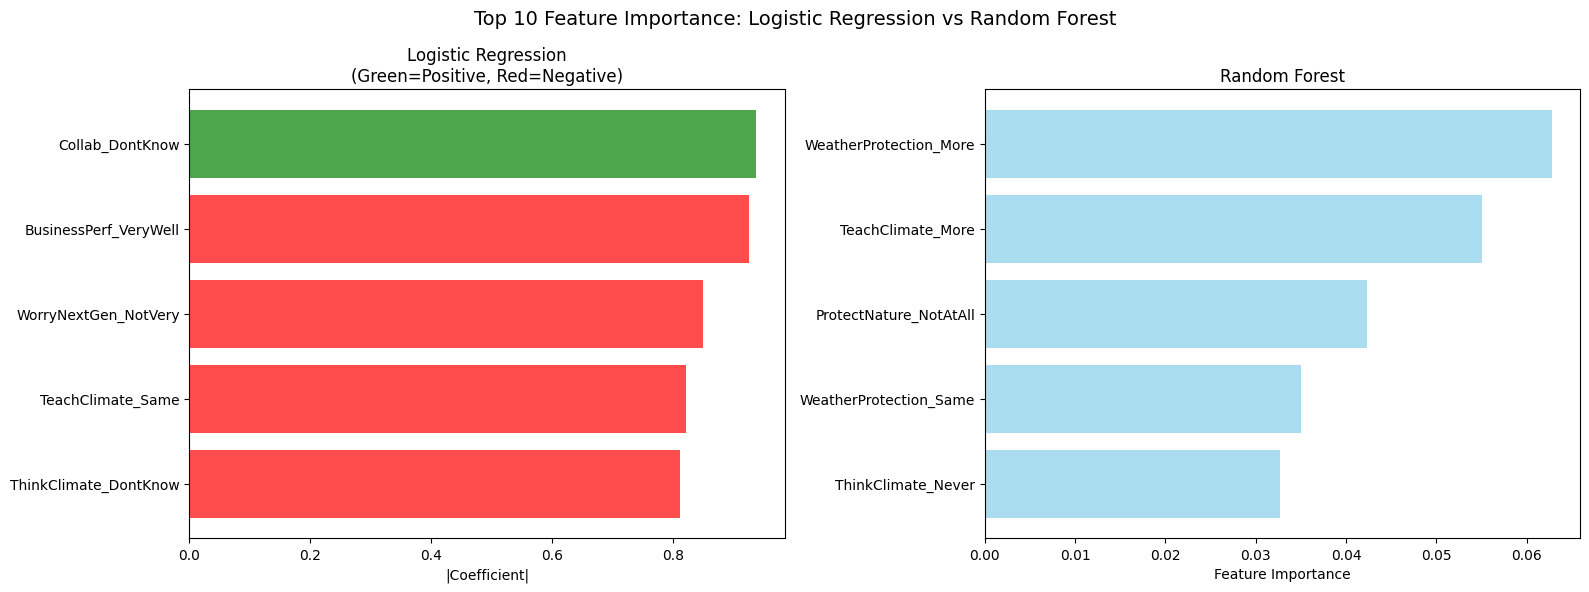

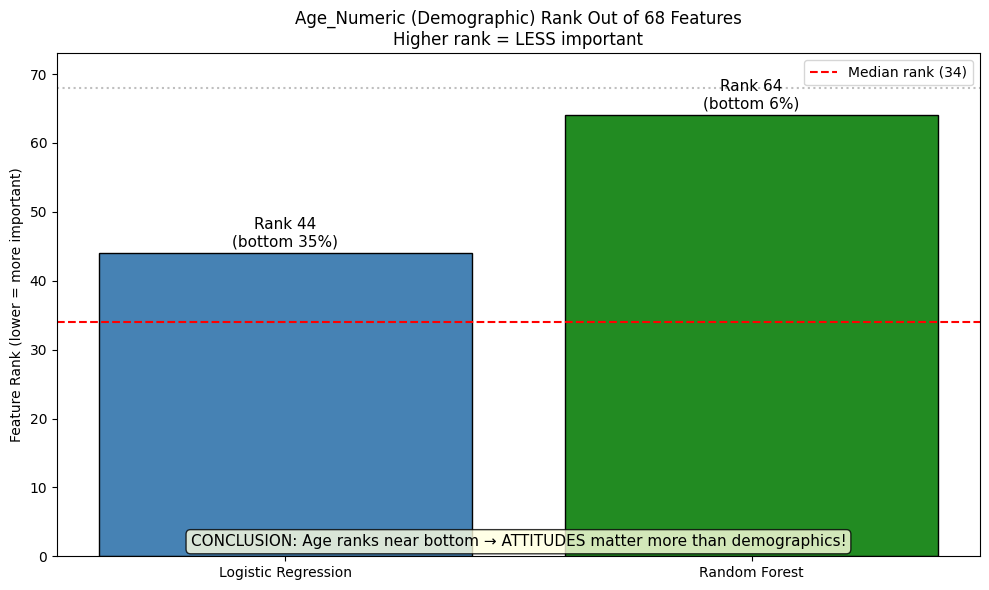

In [75]:
print("Loading preprocessed data...")
X, y, feature_cols, df = load_preprocessed_data(PREPROCESSED_DATA_FILE)

print(f"Dataset: {X.shape[0]} observations, {X.shape[1]} features")
print(f"Target distribution: {y.value_counts().to_dict()}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining set: {X_train.shape[0]} observations")
print(f"Test set: {X_test.shape[0]} observations")

print("Training Logistic Regression...")
lr_model, lr_pred, lr_metrics, scaler = logistic_regression(X_train, y_train, X_test, y_test)
print("Logistic Regression Done!")

print("\nTraining Random Forest...")
rf_model, rf_pred, rf_metrics = random_forest(X_train, y_train, X_test, y_test)
print("Random Forest Done!")

model_comparison(lr_metrics, rf_metrics)

lr_importance, rf_importance = get_features(lr_model, rf_model, feature_cols, scaler)

feature_importance(lr_importance, rf_importance, top_n=5)

analyse_demographics_vs_attitudes(lr_importance, rf_importance)

plot_model_comparison(lr_metrics, rf_metrics)
plot_feature_importance_comparison(lr_importance, rf_importance, 5)
plot_demographics_vs_attitudes(lr_importance, rf_importance)

In [ ]:
def create_feature_name_clustering(question, response):
    q_map = {
        'Countries working together': 'Collab', 
        'Rich countries helping poor': 'RichHelp',
        'Thinking about climate change': 'ThinkClimate', 
        'Worry compared to last year': 'WorryVsLastYr',
        'Worry for next generation': 'WorryNextGen', 
        'Extreme weather experience': 'ExtremeWeather',
        'Effects on big decisions': 'EffectDecisions', 
        'Strengthening commitments': 'Strengthen',
        'Renewable energy transition': 'RenewableTransition', 
        'Protect and restore nature': 'ProtectNature',
        'Protection from extreme weather': 'WeatherProtection', 
        'Teaching about climate change': 'TeachClimate',
        'Country performance': 'CountryPerf', 
        'Big businesses performance': 'BusinessPerf',
        'Who has had most impact': 'MostImpact'
    }
    r_map = {
        "Don't know": 'DontKnow', 'About the same as now': 'Same', 
        'About the same': 'Same', 'About the same as usual': 'Same',
        'Yes - they should work together despite their disagreements': 'Yes',
        'No - they should work separately': 'No',
        "It doesn't matter - no country should work on climate change": 'DoesntMatter',
        'More help': 'More', 'Less help': 'Less', 'Daily': 'Daily', 
        'Weekly': 'Weekly', 'A few times a year': 'FewTimesYear', 'Never': 'Never',
        'More worried': 'More', 'Less worried': 'Less', 'Extremely': 'Extremely',
        'Very': 'Very', 'Somewhat': 'Somewhat', 'Not very': 'NotVery',
        'Not at all': 'NotAtAll', 'Worse than usual': 'Worse',
        'Better than usual': 'Better', 'A lot': 'ALot', 'A little': 'ALittle',
        'Strengthen': 'Strengthen', 'Keep them the same': 'KeepSame', 
        'Weaken': 'Weaken', 'Very quickly': 'VeryQuickly',
        'Somewhat quickly': 'SomewhatQuickly', 'Slowly': 'Slowly',
        'More protection': 'More', 'Less protection': 'Less', 
        'More': 'More', 'Less': 'Less', 'Very well': 'VeryWell',
        'Somewhat well': 'SomewhatWell', 'Neither well nor badly': 'Neutral',
        'Somewhat badly': 'SomewhatBadly', 'Very badly': 'VeryBadly',
        'Government': 'Govt', 'The United Nations': 'UN',
        'Campaigners and activists': 'Activists',
        'Faith and community leaders': 'FaithLeaders', 
        'Big business': 'BigBiz', 'The European Union (EU)': 'EU'
    }
    return f"{q_map.get(question, question)}_{r_map.get(response, response)}"

In [ ]:
def prepare_country_data(file_path):
    df = pd.read_excel(file_path)
    
    df_by_country = df[(df['Country'] != 'Global') & (df['Age'] == 'All Ages') & (df['Education'] == 'All Education')].copy()
    
    df_by_country['Feature'] = df_by_country.apply(
        lambda row: create_feature_name_clustering(row['Question Text (Short)'], row['Response']), axis=1)
    
    df_wide = df_by_country.pivot_table(
        index='Country',
        columns='Feature',
        values='Weighted Mean',
        aggfunc='first'
    ).reset_index()
    
    df_wide.columns.name = None
    
    return df_wide
    

In [56]:
def add_regions(df):
    region_mapping = {
        # Africa
        'Algeria': 'Africa', 'Benin': 'Africa', 'Burkina Faso': 'Africa',
        'Comoros (the)': 'Africa', "Côte d'Ivoire": 'Africa',
        'Democratic Republic of the Congo': 'Africa', 'Egypt': 'Africa',
        'Ethiopia': 'Africa', 'Ghana': 'Africa', 'Kenya': 'Africa',
        'Madagascar': 'Africa', 'Morocco': 'Africa', 'Mozambique': 'Africa',
        'Niger (the)': 'Africa', 'Nigeria': 'Africa', 'South Africa': 'Africa',
        'Sudan (the)': 'Africa', 'Tanzania (the United Republic of)': 'Africa',
        'Tunisia': 'Africa', 'Uganda': 'Africa', 'Zimbabwe': 'Africa',
        
        # Asia
        'Afghanistan': 'Asia', 'Bangladesh': 'Asia', 'Bhutan': 'Asia',
        'Cambodia': 'Asia', 'China': 'Asia', 'India': 'Asia',
        'Indonesia': 'Asia', 'Iran (Islamic Republic of)': 'Asia',
        'Iraq': 'Asia', 'Japan': 'Asia', 'Jordan': 'Asia',
        'Kyrgyzstan': 'Asia', 'Lao PDR': 'Asia', 'Myanmar': 'Asia',
        'Nepal': 'Asia', 'Pakistan': 'Asia', 'Philippines (the)': 'Asia',
        'Republic of Korea (the)': 'Asia', 'Saudi Arabia': 'Asia',
        'Sri Lanka': 'Asia',
        
        # Europe
        'Czechia': 'Europe', 'France': 'Europe', 'Germany': 'Europe',
        'Greece': 'Europe', 'Italy': 'Europe', 'Romania': 'Europe',
        'Russian Federation (the)': 'Europe', 'Spain': 'Europe',
        'United Kingdom of Great Britain and Northern Ireland (the)': 'Europe',
        
        # North America
        'Canada': 'North America', 
        'United States of America (the)': 'North America',
        'Mexico': 'North America',
        
        # Central America & Caribbean
        'Barbados': 'Central America & Caribbean', 
        'Dominican Republic (the)': 'Central America & Caribbean',
        'El Salvador': 'Central America & Caribbean', 
        'Guatemala': 'Central America & Caribbean',
        'Haiti': 'Central America & Caribbean', 
        'Honduras': 'Central America & Caribbean',
        'Nicaragua': 'Central America & Caribbean',
        
        # South America
        'Argentina': 'South America', 'Brazil': 'South America',
        'Colombia': 'South America', 'Ecuador': 'South America',
        'Paraguay': 'South America', 'Peru': 'South America',
        
        # Oceania
        'Australia': 'Oceania', 'Fiji': 'Oceania', 
        'Papua New Guinea': 'Oceania', 'Samoa': 'Oceania',
        'Solomon Islands': 'Oceania', 'Vanuatu': 'Oceania'
    }
    
    df['Region'] = df['Country'].map(region_mapping)
    return df

In [57]:
def find_optimal_k(X_scaled, k_range=range(2, 11)):    
    scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        scores.append((k, score))
    
    # Return k with highest silhouette score
    best_k = max(scores, key=lambda x: x[1])[0]
    return best_k, scores

In [58]:
def perform_clustering(X_scaled, n_clusters=3):
    # K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    
    # Hierarchical (Ward's method)
    linkage_matrix = linkage(X_scaled, method='ward')
    hier_labels = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust') - 1
    
    return kmeans_labels, hier_labels


In [59]:
def get_cluster_profiles(df, feature_cols, cluster_col='Cluster'):
    return df.groupby(cluster_col)[feature_cols].mean()


In [77]:
def plot_cluster_profiles_heatmap(df, cluster_col='Cluster'):
    key_features = [
        'Strengthen_Strengthen', 'RenewableTransition_VeryQuickly',
        'WorryNextGen_Extremely', 'Collab_Yes', 'RichHelp_More',
        'ProtectNature_ALot', 'TeachClimate_More', 'ExtremeWeather_Worse'
    ]
    
    # Filter to only existing features
    existing_features = [f for f in key_features if f in df.columns]
    
    profiles = df.groupby(cluster_col)[existing_features].mean()
    
    # Rename clusters for display
    profiles.index = [f'Cluster {i}' for i in profiles.index]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.heatmap(profiles.T, annot=True, fmt='.1f', cmap='RdYlGn', 
                linewidths=0.5, ax=ax, cbar_kws={'label': 'Mean %'})
    
    ax.set_title('Cluster Profiles: Mean Values for Key Climate Attitudes', fontsize=14)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Attitude Feature')
    
    plt.tight_layout()
    plt.show()

In [79]:
def plot_regional_distribution(df, cluster_col='Cluster'):
    # Create crosstab
    cross_tab = pd.crosstab(df[cluster_col], df['Region'])
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    cross_tab.plot(kind='bar', stacked=True, ax=ax, colormap='Set3', edgecolor='black')
    
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Number of Countries')
    ax.set_title('Regional Distribution Across Clusters')
    ax.set_xticklabels([f'Cluster {i}' for i in cross_tab.index], rotation=0)
    ax.legend(title='Region', bbox_to_anchor=(1.02, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

CLUSTERING ANALYSIS: COUNTRY TYPOLOGIES
Preparing country-level data...
Countries: 72, Features: 71
Scaling features...
Finding optimal number of clusters...
   Best K by silhouette score: 2
   Using K=3 for interpretability
Performing clustering (K=3)...
Adding world regions...
Applying PCA...
Variance explained: 34.1%

Cluster distribution:
Cluster 0: 20 countries

Regional distribution:
Cluster                      0  1   2
Region                               
Africa                       0  0  21
Asia                         5  3  12
Central America & Caribbean  5  0   2
Europe                       3  6   0
North America                1  2   0
Oceania                      0  2   4
South America                6  0   0
Cluster 1: 13 countries

Regional distribution:
Cluster                      0  1   2
Region                               
Africa                       0  0  21
Asia                         5  3  12
Central America & Caribbean  5  0   2
Europe                     

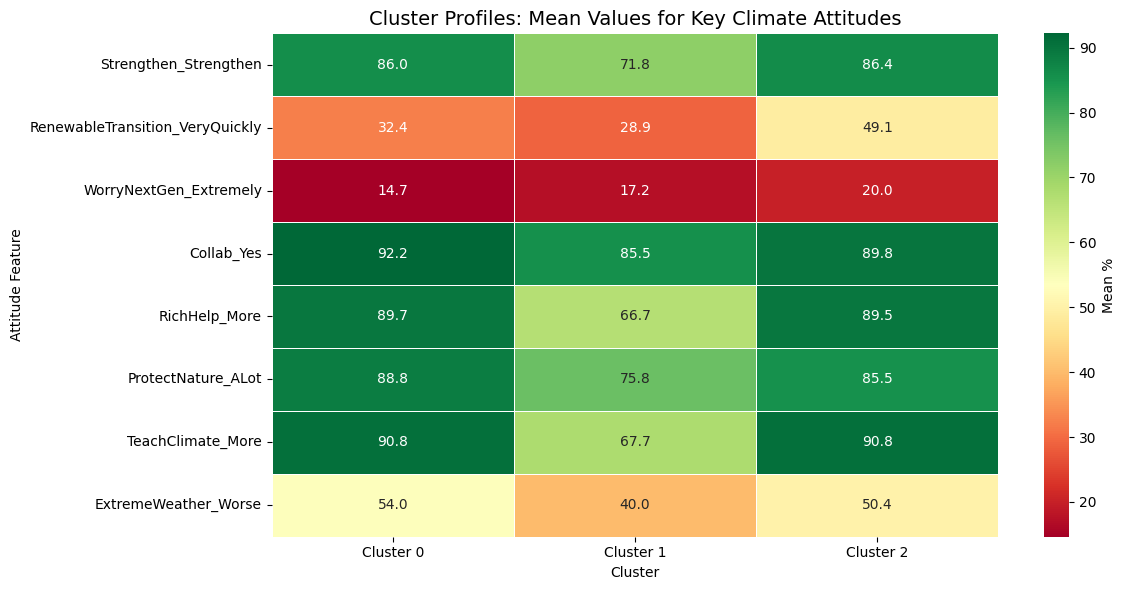

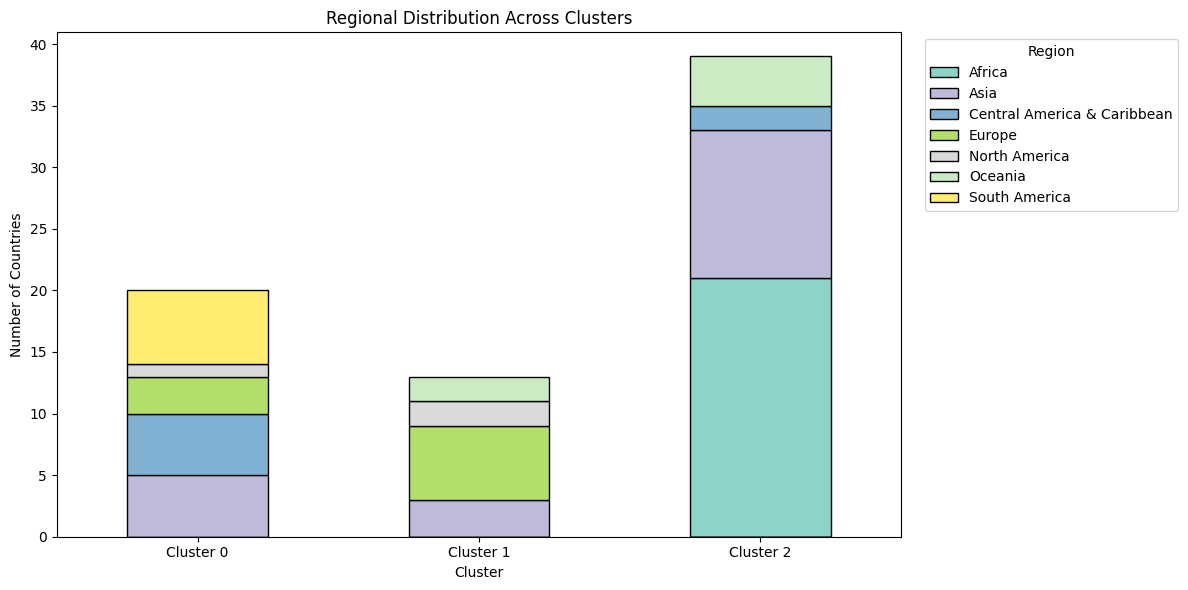

In [ ]:
print("CLUSTERING ANALYSIS: COUNTRY TYPOLOGIES")

print("Preparing country-level data...")
df = prepare_country_data(DATA_FILE)
print(f"Countries: {len(df)}, Features: {len(df.columns) - 1}")

print("Scaling features...")
countries = df['Country']
X = df.drop('Country', axis=1)
feature_cols = X.columns.tolist()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Finding optimal number of clusters...")
best_k, scores = find_optimal_k(X_scaled)
print(f"   Best K by silhouette score: {best_k}")
print(f"   Using K={N_CLUSTERS} for interpretability")

print(f"Performing clustering (K={N_CLUSTERS})...")
kmeans_labels, hier_labels = perform_clustering(X_scaled, N_CLUSTERS)

df['Cluster'] = kmeans_labels
df['Hier_Cluster'] = hier_labels

print("Adding world regions...")
df = add_regions(df)
    
print("Applying PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PC1'] = X_pca[:, 0]
df['PC2'] = X_pca[:, 1]
print(f"Variance explained: {sum(pca.explained_variance_ratio_)*100:.1f}%")


print("\nCluster distribution:")
for cluster in sorted(df['Cluster'].unique()):
    count = (df['Cluster'] == cluster).sum()
    print(f"Cluster {cluster}: {count} countries")
    
    print("\nRegional distribution:")
    print(pd.crosstab(df['Region'], df['Cluster']))
    
# Print cluster profiles for key features
key_features = [
    'Strengthen_Strengthen', 'RenewableTransition_VeryQuickly',
    'WorryNextGen_Extremely', 'Collab_Yes', 'RichHelp_More'
]

print("\nCluster profiles (key features):")
profiles = get_cluster_profiles(df, key_features)
print(profiles.round(1))

plot_cluster_profiles_heatmap(df)
plot_regional_distribution(df)

        